# Проект: классификация

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [1]:
#!pip freeze > requirements.txt

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [289]:
df = pd.read_csv('Data/bank_fin.csv', sep = ';')

In [290]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum().nlargest(10)
# balance 25

balance      25
age           0
job           0
marital       0
education     0
default       0
housing       0
loan          0
contact       0
day           0
dtype: int64

### Задание 2

In [291]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()
# unknown

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [292]:
df['education'].unique()
# unknown

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

### Задание 3

In [293]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace('$', '').str.replace(' ', '').str.replace(',', '.')
df['balance'] = df['balance'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


Задание 2.3

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [294]:
round(df['balance'].mean(), 3)
# 1529.129

1529.129

### Задание 4

In [295]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].replace([np.nan], df['balance'].median())

Задание 2.4

Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.

In [296]:
round(df['balance'].mean(), 3)
# 1526.936

1526.936

### Задание 5

In [297]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace(['unknown'], df['job'].mode())
df['education'] = df['education'].replace(['unknown'], df['education'].mode())

Задание 2.5

После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [298]:
round(df[((df['job'] == df['job'].value_counts().nlargest(1).index[0]) & (df['education'] == df['education'].value_counts().nlargest(1).index[0]))]['balance'].mean(), 3)
# 1598.883

1598.883

### Задание 6

In [299]:
# удалите все выбросы для признака balance
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    #x = np.log(data[feature])
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

# Задание 2.6
# Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.
_, df, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')
print('lower_bound: {}'.format(round(lower_bound)))
print('upper_bound: {}'.format(round(upper_bound)))
# lower_bound: -2241
# upper_bound: 4063

lower_bound: -2241
upper_bound: 4063


Задание 2.7

Сколько объектов осталось после удаления всех выбросов?

In [300]:
df.shape[0]
# 10105

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [301]:
# Сколько клиентов открыли депозит?
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

Deposit "no" : 5424
Deposit "yes": 4681


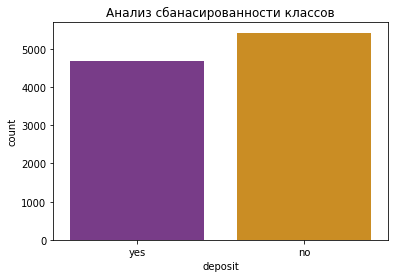

In [302]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
cplot = sns.countplot(x='deposit', data=df, palette='CMRmap')
cplot.set_title('Анализ сбанасированности классов')
deposit_part = df['deposit'].value_counts(normalize=False)
print('Deposit "no" : {}'.format(deposit_part[0]))
print('Deposit "yes": {}'.format(deposit_part[1]))

#### Вывод
Класссы сбалансированы

### Задания 2 и 3

In [303]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Интерпретация
#### age (возраст)
Минимальное: 18<br>
Максимальное: 95<br>
Среднее: 41<br>
Медианное: 38<br>
Комментарий: ничего необычного или подозрительного<br>
#### balance (баланс)
Минимальное: -2049<br>
Максимальное: 4063<br>
Среднее: 808<br>
Медианное: 445<br>
Комментарий: похоже, на счёте допустим отрицательный баланс, это можно дополнительно исследовать <br>
#### day (день, в который был последний контакт)
Минимальное: 1<br>
Максимальное: 31<br>
Среднее: 16<br>
Медианное: 15<br>
Комментарий: ничего необычного или подозрительного <br>
#### duration (продолжительность контакта в секундах)
Минимальное: 2<br>
Максимальное: 3881<br>
Среднее: 369<br>
Медианное: 252<br>
Комментарий: ничего необычного или подозрительного; в среднем на контакт уходит 6 мин. <br>
#### campaign (количество контактов с этим клиентом в течение текущей кампании)
Минимальное: 1<br>
Максимальное: 43 <br>
Среднее: 2,5 <br>
Медианное: 2 <br>
Комментарий: 43 контакта заслуживает внимания, похоже на выброс <br>
#### pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)
Минимальное: -1 <br>
Максимальное: 854 <br>
Среднее: 51 <br>
Медианное: -1 <br>
Комментарий: очень много значений "-1"; похоже, это означает "нет данных" <br>
#### previous (количество контактов до текущей кампании)
Минимальное: 0 <br>
Максимальное: 58 <br>
Среднее: 0,8 <br>
Медианное: 0 <br>
Комментарий: много осутствующих контактов до текущей компании

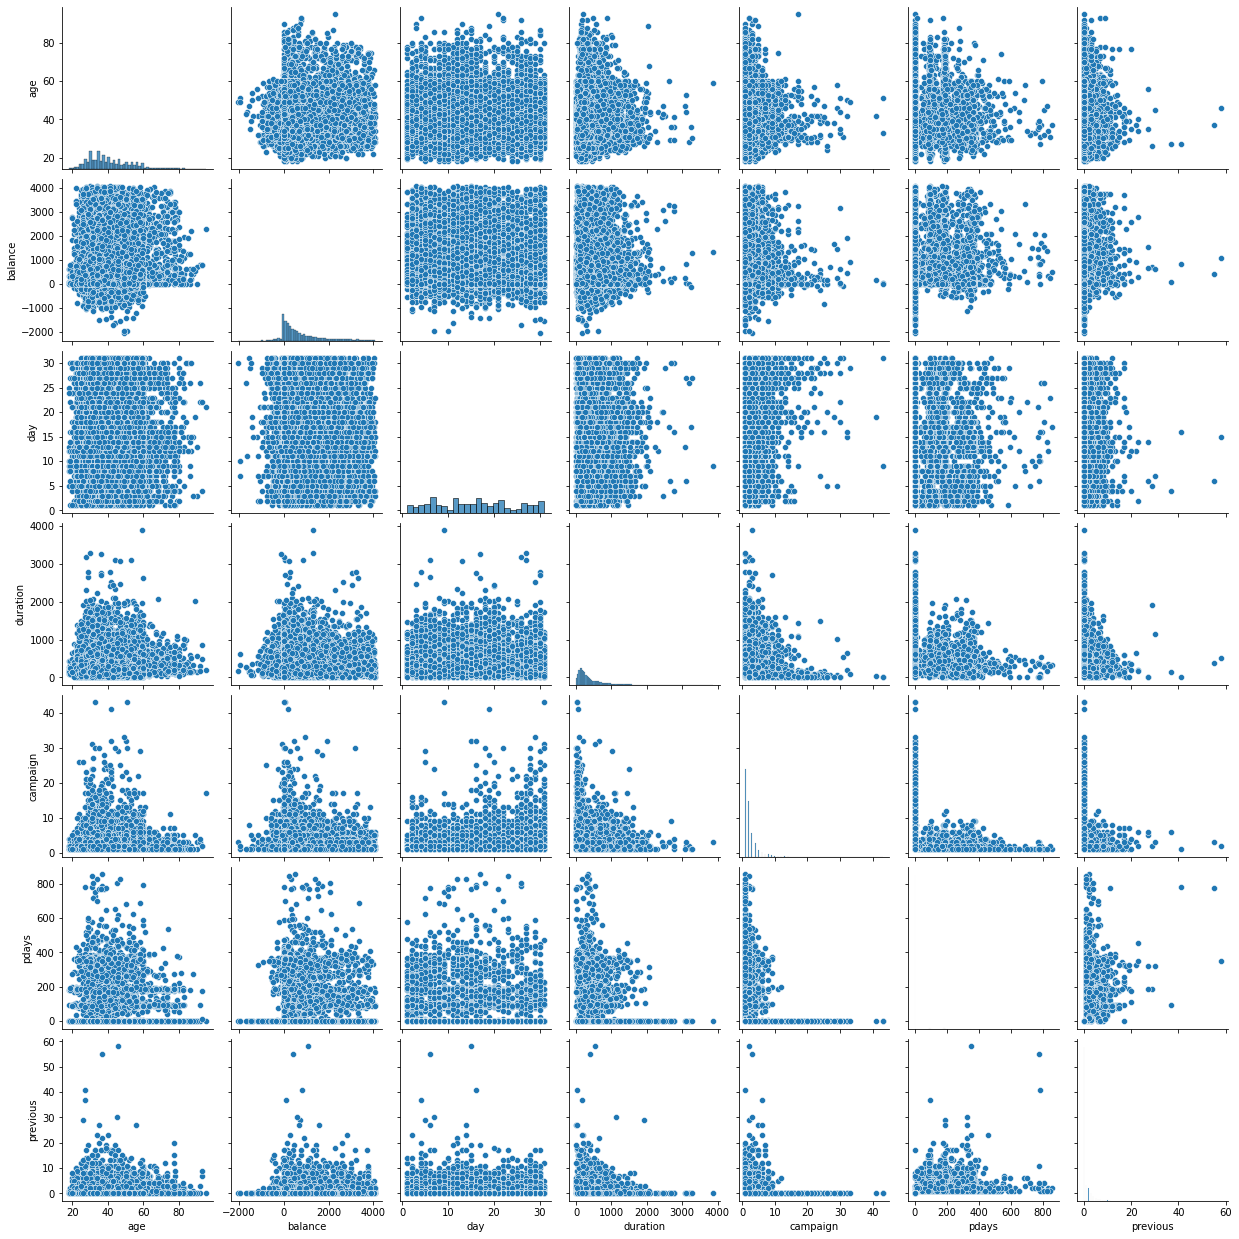

In [304]:
# Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.
sns.pairplot(df)

### Задания 4 и 5

In [305]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


#### Интерпретация
Ничего подозрительного.<br>
Уникальных значений в каждом признаке не много. Достаточно простого кодирования (бинарного и порядкового).

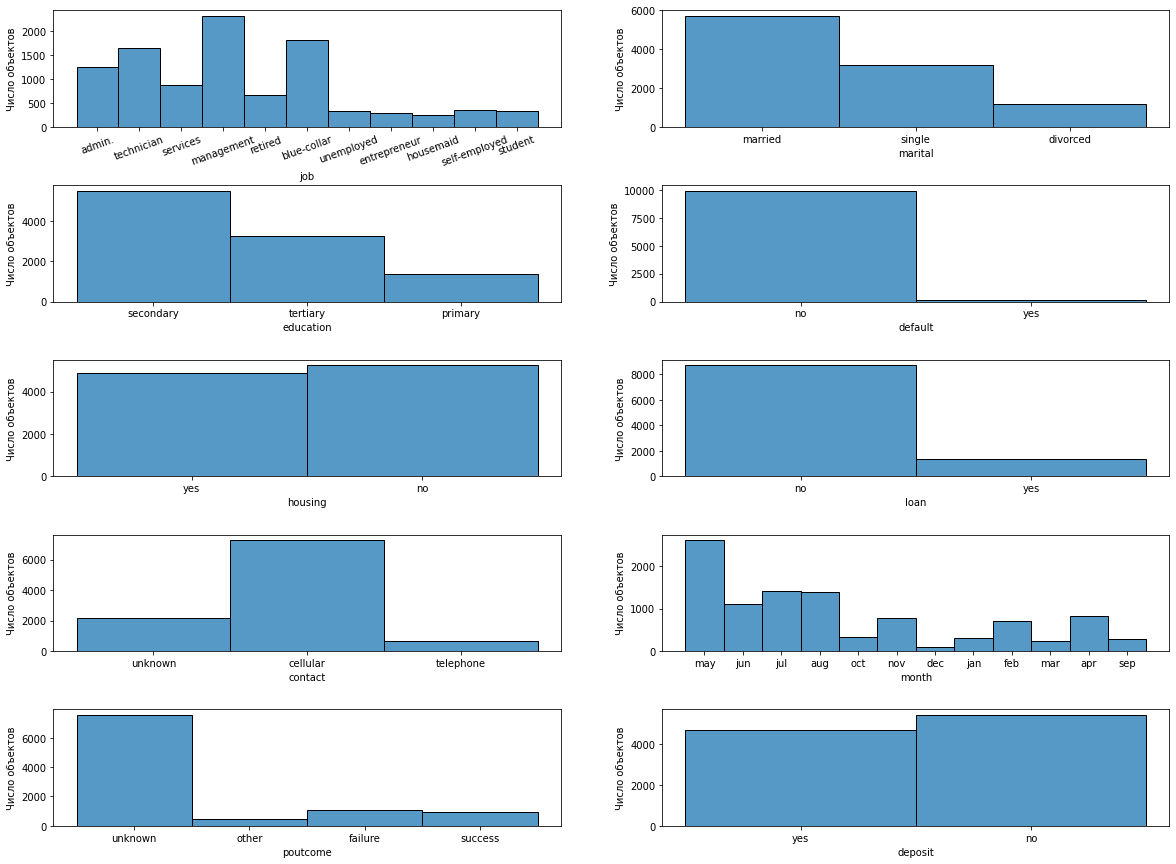

In [306]:
#постройте визуализации, иллюстрирующие результаты
n = df.dtypes.value_counts()['object']
fig, axes = plt.subplots(nrows=n//2 + n%2, ncols=2, figsize=(10*2, 5*3))
plt.subplots_adjust(hspace=.5)

hp_list = []
for i in list(range(0, n, 1)):
    hp = sns.histplot(
        data=df, 
        x=df.dtypes[df.dtypes == 'object'].index[i], 
        bins=30,
        ax=axes[i//2, i%2])
    hp.set_ylabel('Число объектов')
    hp_list.append(hp)
    
hp_list[0].tick_params(axis='x', rotation=20)

### Задание 6

In [307]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df[(df['deposit'] == 'yes')]['poutcome'].value_counts()
# success

unknown    3008
success     861
failure     547
other       265
Name: poutcome, dtype: int64

### Задание 7

In [308]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df[(df['deposit'] == 'no')]['month'].value_counts().index[0]
# may

'may'

### Задание 8

Text(0.5, 1.0, 'Распределение депозитов по возрастам')

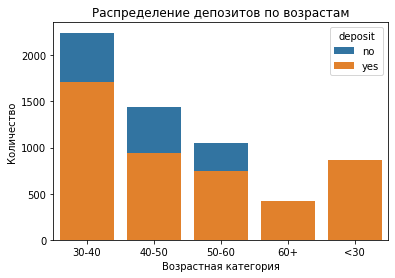

In [309]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
#df['age_range'] = df['age'].apply(lambda x: '<30' if x < 30 else '30-40' if x >= 30 and x < 40 else '40-50' if x >= 40 and x < 50 else '50-60' if x >= 50 and x < 60 else '60+')
df['age_range'] = df['age'].apply(lambda x: '<30' if x < 30 else '30-40' if x >= 30 and x < 40 else '40-50' if x >= 40 and x < 50 else '50-60' if x >= 50 and x <= 60 else '60+')
#df['age_range'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
#df['age_range'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['0-30','30-40','40-50','50-60','60+'])
#df['age_range'] = df['age'].apply(lambda x: '0-30' if x < 30 else '30-40' if x >= 30 and x < 40 else '40-50' if x >= 40 and x < 50 else '50-60' if x >= 50 and x <= 60 else '60+')
# После создания этой переменной постройте диаграмму (на ваш вкус), которая, с вашей точки зрения, сможет наилучшим образом отобразить 
# различия в количестве открытых/не открытых депозитов для каждой возрастной группы.
plt = sns.barplot(
    data=df[['age_range', 'deposit', 'month']].groupby(
    by=['age_range', 'deposit'],
    as_index=False
)[['month']].count(),
    x='age_range',
    y='month',
    hue='deposit',
    orient='v',
    ci=None,
    dodge=False
)
plt.set_xlabel('Возрастная категория')
plt.set_ylabel('Количество')
plt.set_title('Распределение депозитов по возрастам')

# "60+", "<30" 

### Задания 9 и 10

Text(0.5, 1.0, 'Распределение депозитов по сем. статусу')

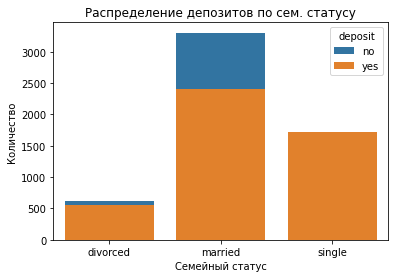

In [310]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt = sns.barplot(
    data=df[['marital', 'deposit', 'month']].groupby(
    by=['marital', 'deposit'],
    as_index=False
)[['month']].count(),
    x='marital',
    y='month',
    hue='deposit',
    orient='v',
    ci=None,
    dodge=False
)
plt.set_xlabel('Семейный статус')
plt.set_ylabel('Количество')
plt.set_title('Распределение депозитов по сем. статусу')

Text(0.5, 1.0, 'Распределение депозитов по образованию')

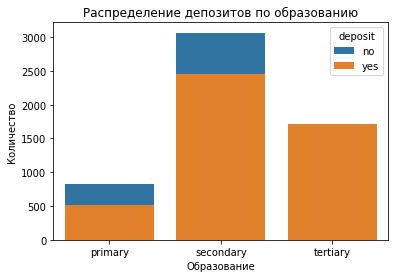

In [311]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plt = sns.barplot(
    data=df[['education', 'deposit', 'month']].groupby(
    by=['education', 'deposit'],
    as_index=False
)[['month']].count(),
    x='education',
    y='month',
    hue='deposit',
    orient='v',
    ci=None,
    dodge=False
)
plt.set_xlabel('Образование')
plt.set_ylabel('Количество')
plt.set_title('Распределение депозитов по образованию')

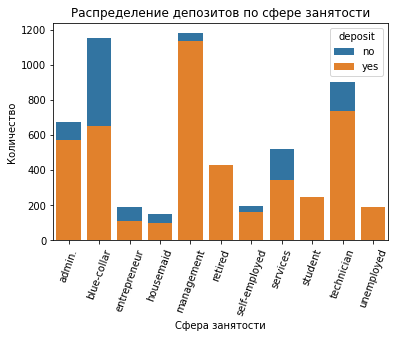

In [312]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt = sns.barplot(
    data=df[['job', 'deposit', 'month']].groupby(
    by=['job', 'deposit'],
    as_index=False
)[['month']].count(),
    x='job',
    y='month',
    hue='deposit',
    orient='v',
    ci=None,
    dodge=False
)
plt.set_xlabel('Сфера занятости')
plt.set_ylabel('Количество')
plt.set_title('Распределение депозитов по сфере занятости')
plt.tick_params(axis='x', rotation=70)

### Задание 11

Text(1083.2181818181816, 0.5, 'Образование')

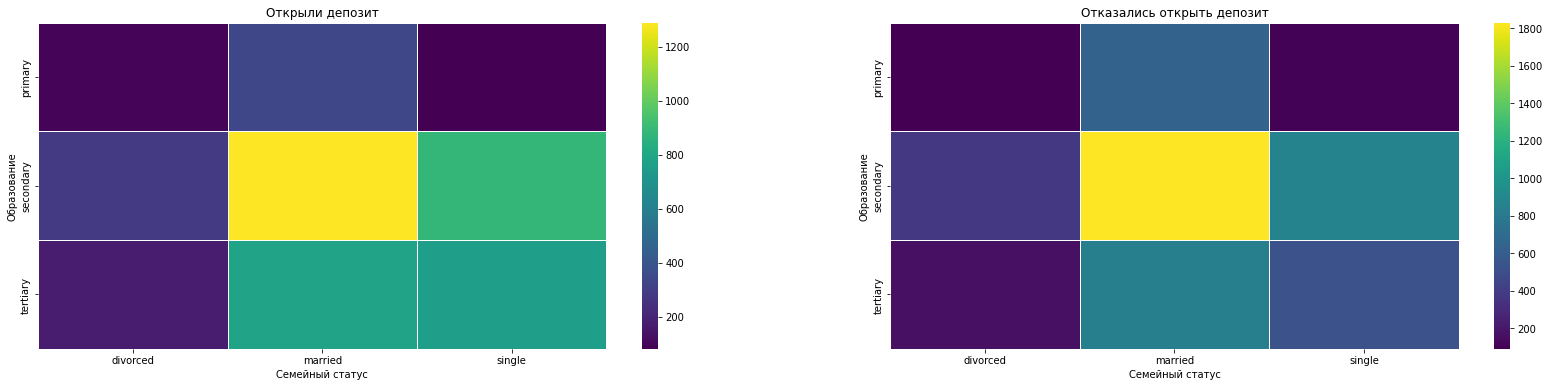

In [313]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Разделите таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. 
# Для каждой части постройте сводную диаграмму (таблицу?) по уровню образования и семейному положению. 
pt_yes = pd.pivot_table(df[['marital', 'education', 'deposit']][(df['deposit'] == 'yes')], values='deposit', index='education', columns='marital', aggfunc='count')
pt_no = pd.pivot_table(df[['marital', 'education', 'deposit']][(df['deposit'] == 'no')], values='deposit', index='education', columns='marital', aggfunc='count')

# Представьте результаты в виде тепловых карт. Различаются ли наиболее популярные группы для открывших депозит и для неоткрывших? 
# Какой вывод вы можете сделать, исходя из полученных данных?
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 6))
pt_y_heatmap = sns.heatmap(
    pt_yes,
    linewidth=1,
    linecolor='w',
    cmap='viridis',
    ax = axes[0]
)
pt_y_heatmap.set_title('Открыли депозит')
pt_y_heatmap.set_xlabel('Семейный статус')
pt_y_heatmap.set_ylabel('Образование')

pt_n_heatmap = sns.heatmap(
    pt_no,
    linewidth=1,
    linecolor='w',
    cmap='viridis',
    ax = axes[1]
)
pt_n_heatmap.set_title('Отказались открыть депозит')
pt_n_heatmap.set_xlabel('Семейный статус')
pt_n_heatmap.set_ylabel('Образование')

#### Вывод
Самая многочисленная группа, взаимодействующая с банком: состоящие в браке (married) и имеющие среднее (secondary) образование.

## Часть 3: преобразование данных

### Задание 1

In [314]:
# преобразуйте уровни образования
# Обработайте его с помощью метода LabelEncoder, используя метод без дополнительных настроек.
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])

# Найдите сумму получившихся значений для признака education
df['education'].sum()
# 11995

11995

### Задания 2 и 3

In [315]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def y_n_to_bin(data, feature):
    data[feature] = data[feature].apply(lambda x: 1 if x == 'yes' else 0)

y_n_to_bin(df, 'default')
y_n_to_bin(df, 'housing')
y_n_to_bin(df, 'loan')
y_n_to_bin(df, 'deposit')

In [316]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.
round(df['deposit'].std(), 3)
# 0.499

0.499

In [317]:
# Задание 4.3
# Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)
# 0.635

0.635

### Задание 4

In [318]:
# создайте дамми-переменные
# Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:
#   'job';
#   'marital';
#   'contact';
#   'month';
#   'poutcome'.
# Создайте для них dummy-переменные и добавьте их в набор данных.
dv = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, dv], axis=1)

In [319]:
# Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.
df.shape[1]-1
# 50

50

In [320]:
# Slack: Сергей Добдин (ментор): Константин, дело в том, что возрастные группы мы не кодируем через get_dummys. Для этого признака мы используем LabelEncoder():
le = LabelEncoder()
df['age_range'] = le.fit_transform(df['age_range'])

### Задания 5 и 6

<AxesSubplot:>

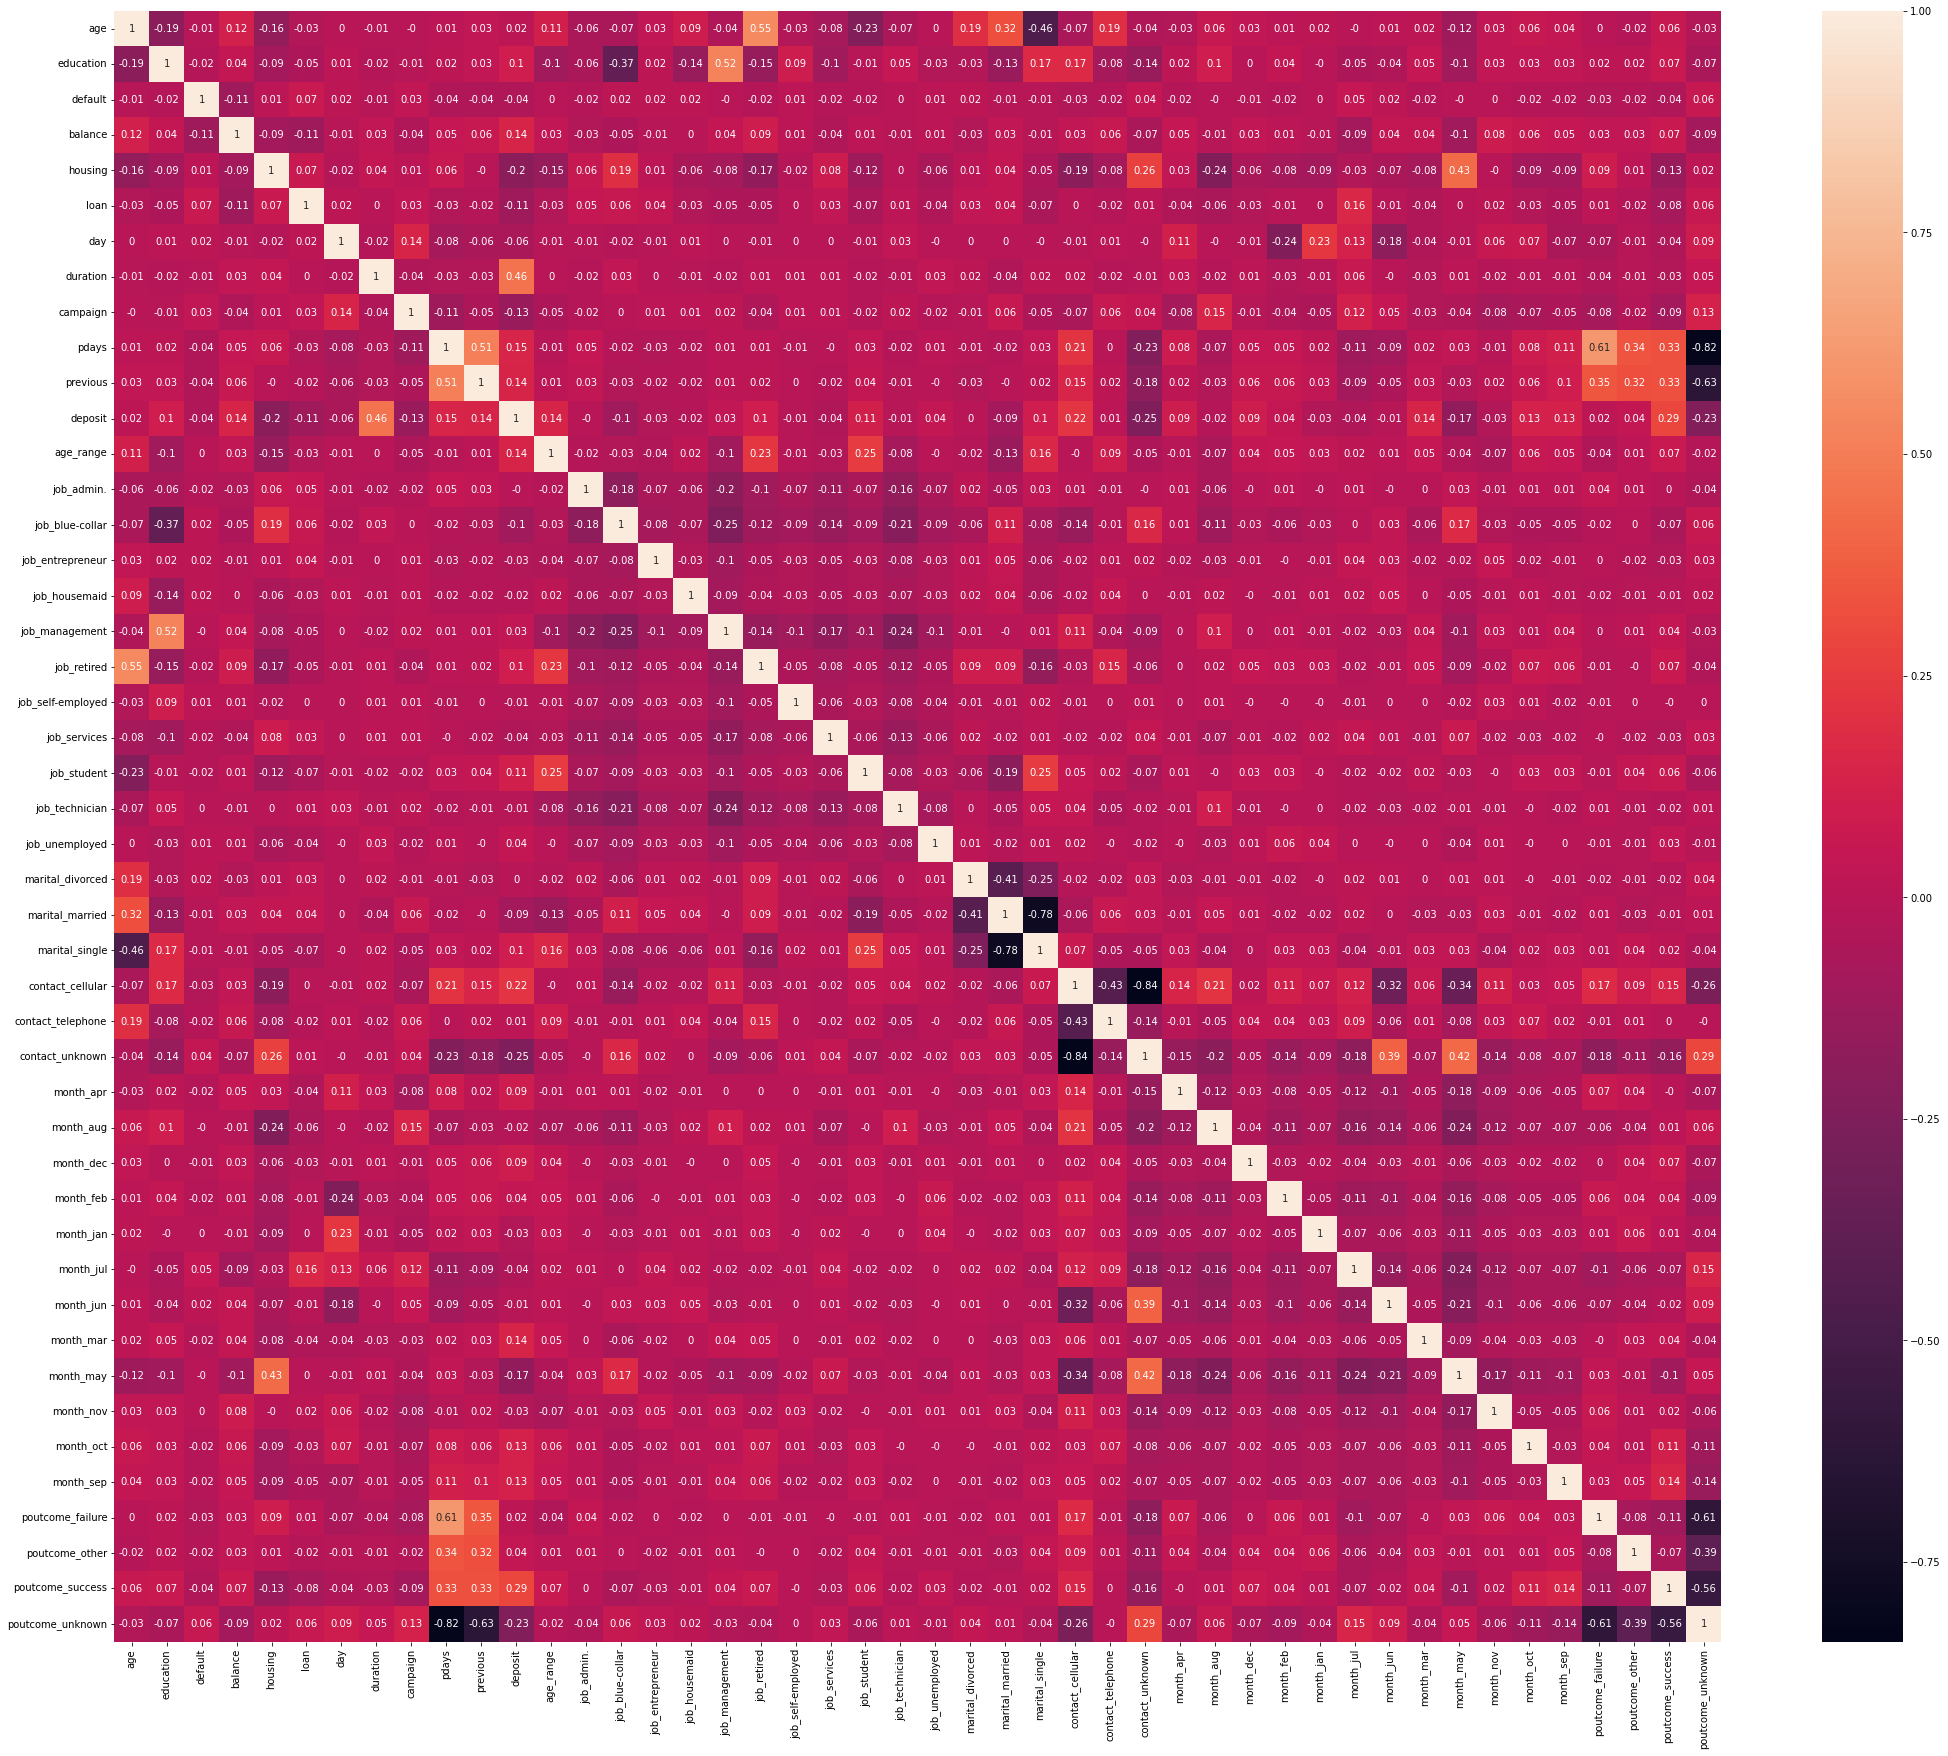

In [321]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(36, 30))
sns.heatmap(round(df.corr(), 2), annot=True)

#### Вывод
Если принять за порог мультиколлинеарности значение +/-0.9, то в данных мультиколлинеарности нет.

Text(0.5, 1.0, 'Корреляции с целевой переменной')

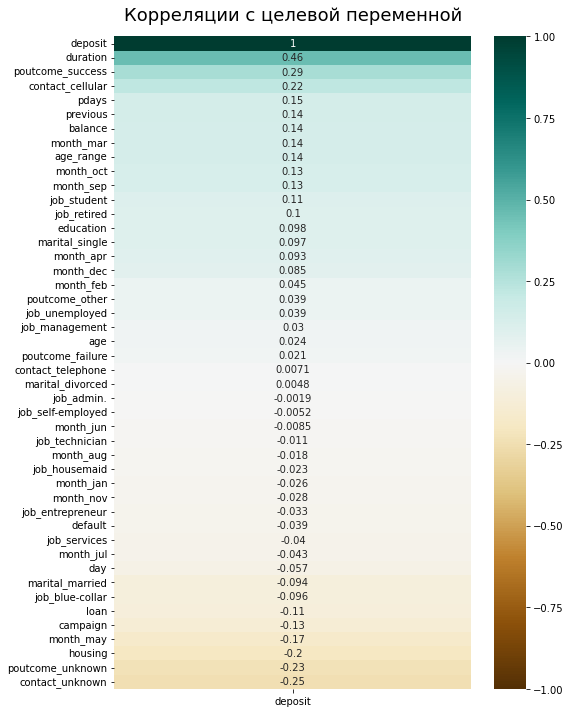

In [322]:
# В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму для ранжированных коэффициентов корреляции.
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['deposit']].sort_values(by='deposit', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Корреляции с целевой переменной', fontdict={'fontsize':18}, pad=16)

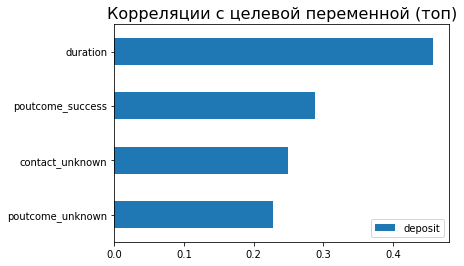

In [323]:
# Второй вариант из Slack (поудобнее)
df.corr()[['deposit']].apply(lambda x: abs(x)).sort_values(by = 'deposit')[-5:-1].plot.barh()
plt.title("Корреляции с целевой переменной (топ)", fontsize = 16)
plt.show()

### Задания 7 и 8

In [324]:
X = df.drop(['deposit', 'job', 'marital', 'contact', 'month', 'poutcome'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [325]:
# рассчитайте необходимые показатели
# Каким получился размер тестовой выборки?
X_test.shape[0]
# 3335
# Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.
round(y_test.mean(), 2)
# 0.46

0.46

### Задание 9

In [326]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
 
fn = selector.get_feature_names_out().tolist()
fn

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_range',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [327]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. 
# Ответ округлите до двух знаков после точки-разделителя.
round(X_test[:, 0].mean(), 2)
# 0.47

0.47

In [328]:
# Возвращаем названия колонок
X_test = pd.DataFrame(X_test, columns=fn)
X_train = pd.DataFrame(X_train, columns=fn)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [329]:
# обучите логистическую регрессию и рассчитайте метрики качества

# В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
# Делаем предсказание
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Для получившейся модели вычислите значение accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
# Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred))) # 0.82
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred))) # 0.81

Accuracy на тренировочной выборке: 0.82
Accuracy на тестовой выборке: 0.81


### Задания 2,3,4

In [330]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train, y_train)

y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

# Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
# Что можно наблюдать после реализации алгоритма и оценки его качества?
# 1.0 vs 0.75 - переобучение

Accuracy на тренировочной выборке: 1.00
Accuracy на тестовой выборке: 0.75


In [331]:
# Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, 
# но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    random_state=42, #генератор случайных чисел
    max_depth=6
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train, y_train)

y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

# Рассчитываем accuracy
print('Accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
# 6 (->0.81) подобрано вручную, но правильным мне кажется значение 7 (->0.82), хотя при этом чуть выше Accuracy на тренировочной выборке: 0.82 -> 0.84

Accuracy на тренировочной выборке: 0.82
Accuracy на тестовой выборке: 0.81


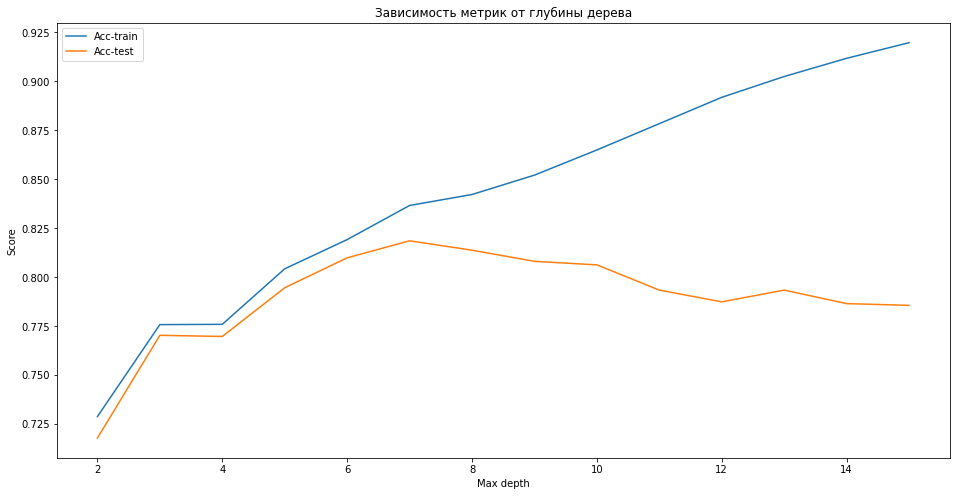

In [332]:
# Графическое представление для задания 5.3
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = dt_clf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
acc_train = []
acc_test = []
# Сгенерируем набор глубин дерева в диапазоне от 2 до 15
max_depths = list(range(2, 16))
#В цикле будем перебирать сгенерированные глубины
for max_depth in max_depths:
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности 
        random_state=42, #генератор случайных чисел
        max_depth=max_depth
    )
    #Обучаем дерево решений
    dt_clf.fit(X_train, y_train)
    y_train_pred = dt_clf.predict(X_train)
    y_test_pred = dt_clf.predict(X_test)
    
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))
    acc_train.append(metrics.accuracy_score(y_train, y_train_pred))
    acc_test.append(metrics.accuracy_score(y_test, y_test_pred))

#Визуализируем метрики при различных max_depth
fig, ax = plt.subplots(figsize=(16, 8)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
#ax.plot(max_depths, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
#ax.plot(max_depths, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
#ax.plot(max_depths, f1_scores, label='F1-score')
#Строим линейный график зависимости F1 от threshold
ax.plot(max_depths, acc_train, label='Acc-train')
#Строим линейный график зависимости F1 от threshold
ax.plot(max_depths, acc_test, label='Acc-test')
#Даем графику название и подписи осям
ax.set_title('Зависимость метрик от глубины дерева')
ax.set_xlabel('Max depth')
ax.set_ylabel('Score')
ax.legend()

### Задание 5

In [333]:
# подберите оптимальные параметры с помощью gridsearch
# Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3,5,7],
              'min_samples_split': [2, 5, 7, 10]
              }
            
random_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    param_grid=param_grid, 
    #cv=5,
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
# Оцените метрику F1 на тестовой выборке для наилучшей комбинации перебираемых параметров. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))
print(metrics.classification_report(y_test, y_test_pred))

CPU times: total: 125 ms
Wall time: 945 ms
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [334]:
# обучите на ваших данных случайный лес
from sklearn.metrics import classification_report

#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf = 5, max_depth = 10, random_state = 42)

#Обучаем модель
rf.fit(X_train, y_train)
# Оцените метрики accuracy и recall для построенной модели на тестовой выборке.
#Выводим значения метрики 
y_test_pred = rf.predict(X_test)
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.83
Test recall: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [335]:
from sklearn.ensemble import GradientBoostingClassifier

# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf = 5, #минимальное число элементов в "листе"
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)

gb.fit(X_train, y_train)
y_test_pred = gb.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# Test F1: 0.82
print(classification_report(y_test, y_test_pred))

Test F1: 0.82
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



#### Вывод
Метрики абсолютно одинаковые. Сложно сказать, какая модель лучше. Можно выбрать любую.

### Задание 4

In [336]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# В этом задании вам необходимо использовать стекинг, объединив те алгоритмы, которые вы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. 
# В качестве метамодели используйте модель логистической регрессии.
# Параметры оставьте те же, что были в ваших алгоритмах в предыдущих заданиях.
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('gb', GradientBoostingClassifier(
                learning_rate=0.05, #темп обучения
                n_estimators=300, #число деревьев
                min_samples_leaf = 5, #минимальное число элементов в "листе"
                max_depth=5, #максимальная глубина дерева
                random_state=42 #генератор случайных чисел
            )),
    ('dt', DecisionTreeClassifier(criterion='entropy', #критерий информативности 
                                 random_state=42 #генератор случайных чисел
                                 #,max_depth=6
                                 ))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
)
#Обучаем модель
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
# Для построенной модели оцените метрику precision на тестовой выборке. В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
print('Test precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Test precision: 0.80


### Задание 5

In [337]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_

# Дальше нужно будет сопоставить X_train.columns и ranking_
# duration - 1
# poutcome_success - 1
# poutcome_unknown - 11

['duration' 'contact_unknown' 'poutcome_success']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_range', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 6,  3,  1, 10,  2, 12,  4, 13,  1,  5,  9,  7,  8,  1, 11])

### Задания 6,7,8

In [342]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# 6
# Для перебора возьмите случайный лес и следующие параметры:
# n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
# max_depth = trial.suggest_int('max_depth', 10, 30, 1);
# min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [343]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-11-10 00:38:12,173] A new study created in memory with name: RandomForestClassifier
[I 2022-11-10 00:38:12,702] Trial 0 finished with value: 0.8561094511715679 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8561094511715679.
[I 2022-11-10 00:38:13,155] Trial 1 finished with value: 0.9217990910515593 and parameters: {'n_estimators': 106, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9217990910515593.
[I 2022-11-10 00:38:13,615] Trial 2 finished with value: 0.856072432094911 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9217990910515593.
[I 2022-11-10 00:38:14,128] Trial 3 finished with value: 0.8515099358472852 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9217990910515593.
[I 2022-11-10 00:38:14,652] Trial 4 finished with value: 0.8584802621313777 and parameters: {'n_e

CPU times: total: 10.2 s
Wall time: 10.3 s


In [345]:
# Введите значение метрики F1 на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
# Введите значение метрики accuracy на тестовой выборке. Ответ округлите до двух знаков после точки-разделителя.
model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print("accuracy на тестовом наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
